In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from  imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [5]:


# ================================
# ⚙️ Feature Generator
# ================================
def generate_features(df, threshold = 0.8 ):
    df_feat = df.copy()

    # Ensure required columns
    for c in ['Open', 'High', 'Low', 'Close', 'Volume']:
        if c not in df_feat.columns:
            raise ValueError(f"Missing column: {c}")

    # ======================================================
    # 1️⃣ RSI + Signal
    # ======================================================
    df_feat['RSI'] = ta.momentum.RSIIndicator(df_feat['Close'], window=14).rsi()
    df_feat['RSI_signal'] = np.where(df_feat['RSI'] > 70, 'Sell',
                              np.where(df_feat['RSI'] < 30, 'Buy', 'Hold'))

    # ======================================================
    # 2️⃣ ATR
    # ======================================================
    df_feat['ATR'] = ta.volatility.AverageTrueRange(
        df_feat['High'], df_feat['Low'], df_feat['Close'], window=14
    ).average_true_range()

    # ======================================================
    # 3️⃣ Moving Averages (EMA, SMA, WMA)
    # ======================================================
    df_feat['EMA_12'] = ta.trend.EMAIndicator(df_feat['Close'], window=12).ema_indicator()
    df_feat['SMA_14'] = ta.trend.SMAIndicator(df_feat['Close'], window=14).sma_indicator()
    df_feat['WMA_14'] = ta.trend.WMAIndicator(df_feat['Close'], window=14).wma()

    df_feat['EMA_relative'] = df_feat['Close'] / df_feat['EMA_12']
    df_feat['MA_relative'] = df_feat['Close'] / df_feat['Close'].rolling(window=14).mean()
    df_feat['SMA_relative'] = df_feat['Close'] / df_feat['SMA_14']
    df_feat['WMA_relative'] = df_feat['Close'] / df_feat['WMA_14']

    # ======================================================
    # 4️⃣ MACD
    # ======================================================
    macd = ta.trend.MACD(df_feat['Close'])
    df_feat['MACD'] = macd.macd()
    df_feat['MACD_signal'] = macd.macd_signal()
    df_feat['MACD_hist'] = macd.macd_diff()
    df_feat['MACD_relative'] = df_feat['MACD'] / df_feat['Close']
    df_feat['MACD_relative_signal'] = df_feat['MACD_signal'] / df_feat['Close']
    df_feat['MACD_relative_histogram'] = df_feat['MACD_hist'] / df_feat['Close']

    # ======================================================
    # 5️⃣ ADX
    # ======================================================
    df_feat['ADX'] = ta.trend.ADXIndicator(
        df_feat['High'], df_feat['Low'], df_feat['Close'], window=14
    ).adx()

    # ======================================================
    # 6️⃣ Stochastic Oscillator
    # ======================================================
    stoch = ta.momentum.StochRSIIndicator(df_feat['Close'], window=14, smooth1=3, smooth2=3)
    df_feat['Stoch_O_k_value'] = stoch.stochrsi_k()
    df_feat['Stoch_O_k_smoothed'] = df_feat['Stoch_O_k_value'].rolling(3).mean()
    df_feat['Stoch_O_d_value'] = stoch.stochrsi_d()
    df_feat['Stoch_O_signal_value'] = df_feat['Stoch_O_k_value'] - df_feat['Stoch_O_d_value']
    df_feat['Stoch_O_signal'] = np.where(df_feat['Stoch_O_signal_value'] > 0, 'Buy', 'Sell')

    # ======================================================
    # 7️⃣ Pivot Points (Classic)
    # ======================================================
    df_feat['pivot_point'] = (df_feat['High'] + df_feat['Low'] + df_feat['Close']) / 3
    df_feat['pivot_support_1'] = 2 * df_feat['pivot_point'] - df_feat['High']
    df_feat['pivot_resistance_1'] = 2 * df_feat['pivot_point'] - df_feat['Low']
    df_feat['pivot_support_2'] = df_feat['pivot_point'] - (df_feat['High'] - df_feat['Low'])
    df_feat['pivot_resistance_2'] = df_feat['pivot_point'] + (df_feat['High'] - df_feat['Low'])
    df_feat['pivot_support_3'] = df_feat['pivot_point'] - 2 * (df_feat['High'] - df_feat['Low'])
    df_feat['pivot_resistance_3'] = df_feat['pivot_point'] + 2 * (df_feat['High'] - df_feat['Low'])

    # ======================================================
    # 8️⃣ Fibonacci Levels & Signal
    # ======================================================
    high_50 = df_feat['High'].rolling(window=50).max()
    low_50 = df_feat['Low'].rolling(window=50).min()
    diff = high_50 - low_50
    fib_236 = high_50 - diff * 0.236
    fib_382 = high_50 - diff * 0.382
    fib_618 = high_50 - diff * 0.618

    df_feat['fibonacci_signal'] = np.where(df_feat['Close'] > fib_236, 'Sell',
                                    np.where(df_feat['Close'] < fib_618, 'Buy', 'Hold'))

    # ======================================================
    # 9️⃣ VWAP (Relative)
    # ======================================================
    vwap_short = ta.volume.VolumeWeightedAveragePrice(
        df_feat['High'], df_feat['Low'], df_feat['Close'], df_feat['Volume'], window=20
    ).volume_weighted_average_price()

    vwap_long = ta.volume.VolumeWeightedAveragePrice(
        df_feat['High'], df_feat['Low'], df_feat['Close'], df_feat['Volume'], window=50
    ).volume_weighted_average_price()

    df_feat['VWAP_relative_short'] = df_feat['Close'] / vwap_short
    df_feat['VWAP_relative_long'] = df_feat['Close'] / vwap_long

    # ======================================================
    # 🔟 Bollinger Bands
    # ======================================================
    bb = ta.volatility.BollingerBands(df_feat['Close'], window=20, window_dev=2)
    df_feat['Bollinger_upper_band'] = bb.bollinger_hband()
    df_feat['Bollinger_lower_band'] = bb.bollinger_lband()
    df_feat['Bollinger_signal'] = np.where(
        df_feat['Close'] > df_feat['Bollinger_upper_band'], 'Sell',
        np.where(df_feat['Close'] < df_feat['Bollinger_lower_band'], 'Buy', 'Hold')
    )

    # ======================================================
    # 1️⃣1️⃣ Ichimoku Cloud
    # ======================================================
    ichi = ta.trend.IchimokuIndicator(df_feat['High'], df_feat['Low'], window1=9, window2=26, window3=52)
    df_feat['ichimoku_c_conversion_line'] = ichi.ichimoku_conversion_line()
    df_feat['ichimoku_c_base_line'] = ichi.ichimoku_base_line()
    df_feat['ichimoku_c_leading_span_a'] = ichi.ichimoku_a()
    df_feat['ichimoku_c_leading_span_b'] = ichi.ichimoku_b()
    df_feat['ichimoku_c_signal'] = np.where(
        df_feat['Close'] > df_feat['ichimoku_c_leading_span_a'], 'Buy',
        np.where(df_feat['Close'] < df_feat['ichimoku_c_leading_span_b'], 'Sell', 'Hold')
    )

    # ======================================================
    # 1️⃣2️⃣ Parabolic SAR (Relative)
    # ======================================================
    psar = ta.trend.PSARIndicator(df_feat['High'], df_feat['Low'], df_feat['Close'])
    df_feat['SAR_relative'] = df_feat['Close'] / psar.psar()

    # ======================================================
    # 1️⃣3️⃣ Market Proxy & Result
    # ======================================================
    df_feat['s&p_move_15m'] = df_feat['Close'].pct_change(periods=3) * 100
    df_feat['Next_Close'] = df_feat['Close'].shift(-1)
    df_feat['Return_%'] = (df_feat['Next_Close'] - df_feat['Close']) / df_feat['Close'] * 100

    df_feat['result'] = df_feat['Return_%'].apply(
        lambda x: 1 if x >= threshold else (0 if x <= -threshold else 2)
    )

    # ======================================================
    # 1️⃣4️⃣ Misc: Exchange + ID
    # ======================================================
    df_feat['exchange'] = 'BubbleStocks'
    df_feat['id'] = np.arange(len(df_feat)) + 100000

    # ======================================================
    # ✅ Clean up
    # ======================================================
    df_feat.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_feat.dropna(inplace=True)
    print("✅ All features generated successfully.")
    return df_feat


# ======================================================
# 🚀 Run Feature Generation
# ======================================================
if __name__ == "__main__":
    df = pd.read_csv("btc_15m_data_2018_to_2025.csv")
    df_final = generate_features(df)
    df_final.to_csv("feature_generated_dataset.csv", index=False)
    print(f"✅ Saved 'feature_generated_dataset.csv' → Rows: {len(df_final)}, Cols: {len(df_final.columns)}")


✅ All features generated successfully.
✅ Saved 'feature_generated_dataset.csv' → Rows: 272539, Cols: 59


In [6]:
df = pd.read_csv('feature_generated_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272539 entries, 0 to 272538
Data columns (total 59 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Open time                     272539 non-null  object 
 1   Open                          272539 non-null  float64
 2   High                          272539 non-null  float64
 3   Low                           272539 non-null  float64
 4   Close                         272539 non-null  float64
 5   Volume                        272539 non-null  float64
 6   Close time                    272539 non-null  object 
 7   Quote asset volume            272539 non-null  float64
 8   Number of trades              272539 non-null  int64  
 9   Taker buy base asset volume   272539 non-null  float64
 10  Taker buy quote asset volume  272539 non-null  float64
 11  Ignore                        272539 non-null  int64  
 12  RSI                           272539 non-nul

In [7]:
df.drop([
    'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Close time', 'Quote asset volume', 'Number of trades',
    'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore',
], axis=1, inplace=True, errors='ignore')

df.to_csv("generated_dataset.csv", index=False)

In [8]:
# Given the imbalance in the database, we intend to employ tree-based models such as Random Forests and XGBoost. 
df['result'].value_counts()

result
2    262098
0      5264
1      5177
Name: count, dtype: int64

In [9]:
# Checking some features to drop
df['exchange'].value_counts()
#pd.pivot_table(df, index = 'exchange', aggfunc = {'result':np.sum})

exchange
BubbleStocks    272539
Name: count, dtype: int64

In [10]:
# print(df.isna().sum())
# print('\n')
# print(df.isnull().sum())

In [11]:
# Categorical Features

print(df['RSI_signal'].value_counts())
print()
print(df['Stoch_O_signal'].value_counts())
print()
print(df['ichimoku_c_signal'].value_counts())
print()
print(df['fibonacci_signal'].value_counts())
print()
print(df['Bollinger_signal'].value_counts())
    
# These features are really imbalanced, I'll just drop them
def drop(df):
    df.drop(['RSI_signal','Stoch_O_signal','ichimoku_c_signal','fibonacci_signal','Bollinger_signal','exchange', 'Return_%' ], axis=1, inplace=True , errors = 'ignore') 
drop(df)

RSI_signal
Hold    250529
Sell     11848
Buy      10162
Name: count, dtype: int64

Stoch_O_signal
Sell    137613
Buy     134926
Name: count, dtype: int64

ichimoku_c_signal
Buy     147413
Sell     92755
Hold     32371
Name: count, dtype: int64

fibonacci_signal
Hold    119602
Buy      90015
Sell     62922
Name: count, dtype: int64

Bollinger_signal
Hold    239996
Sell     16297
Buy      16246
Name: count, dtype: int64


In [12]:
# df.info()

# **Scaling**

In [13]:
temp = df['result']
from sklearn.preprocessing import StandardScaler
def scaling(df):   
    scaler = StandardScaler()
    scaler.fit(df)
    df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
    return df
df = scaling(df)

In [14]:
df['result'] = temp

# **Training**

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:
df.columns
df.shape

(272539, 40)

In [17]:
df.drop([
    'SMA_14' , 'WMA_14', 'pivot_support_1' , 'pivot_resistance_1' ,'pivot_support_2' ,'pivot_resistance_2',
    'pivot_support_3', 'pivot_resistance_3', 'ichimoku_c_leading_span_a' ,'ichimoku_c_leading_span_b','ichimoku_c_base_line','Bollinger_lower_band',
    'ichimoku_c_conversion_line','EMA_relative','SMA_relative','Return_%'
], axis=1, inplace=True, errors='ignore')


In [18]:
def create_lag(df):
    for feature in df.columns:
        new_column_name = f"{feature}_lag{1}"  
        df[new_column_name] = df[feature].shift(1)
        new_column_name2 = f"{feature}_lag{2}"  
        df[new_column_name2] = df[feature].shift(2)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X = df.drop(['result'], axis=1)
y = df['result']

create_lag(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [20]:
X_train.shape

(218031, 72)

/tmp/ipykernel_39077/1231833009.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data =df, x ='result', palette='viridis')


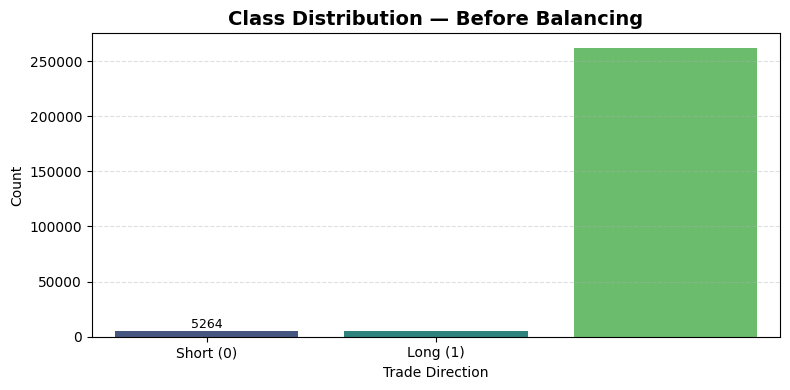

In [21]:
# ============================
# 🎯 Class Distribution Before Balancing
# ============================
plt.figure(figsize=(8, 4), dpi=100)
ax = sns.countplot(data =df, x ='result', palette='viridis')
ax.bar_label(ax.containers[0], fmt='%.0f', fontsize=9)
plt.title("Class Distribution — Before Balancing", fontsize=14, fontweight='bold')
plt.xticks([0, 1], ['Short (0)', 'Long (1)'])
plt.xlabel("Trade Direction")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



In [22]:
# under = RandomUnderSampler(sampling_strategy='majority')
# X_train, y_train = under.fit_resample(X_train,y_train)

/tmp/ipykernel_39077/693078824.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_train, palette='mako')


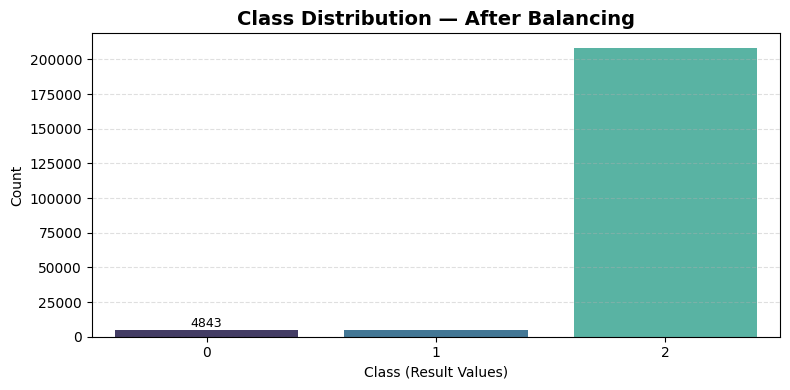

In [23]:
# ============================
# 🎯 Class Distribution — After Balancing
# ============================
plt.figure(figsize=(8, 4), dpi=100)
ax = sns.countplot(x=y_train, palette='mako')
ax.bar_label(ax.containers[0], fmt='%.0f', fontsize=9)
plt.title("Class Distribution — After Balancing", fontsize=14, fontweight='bold')
plt.xlabel("Class (Result Values)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

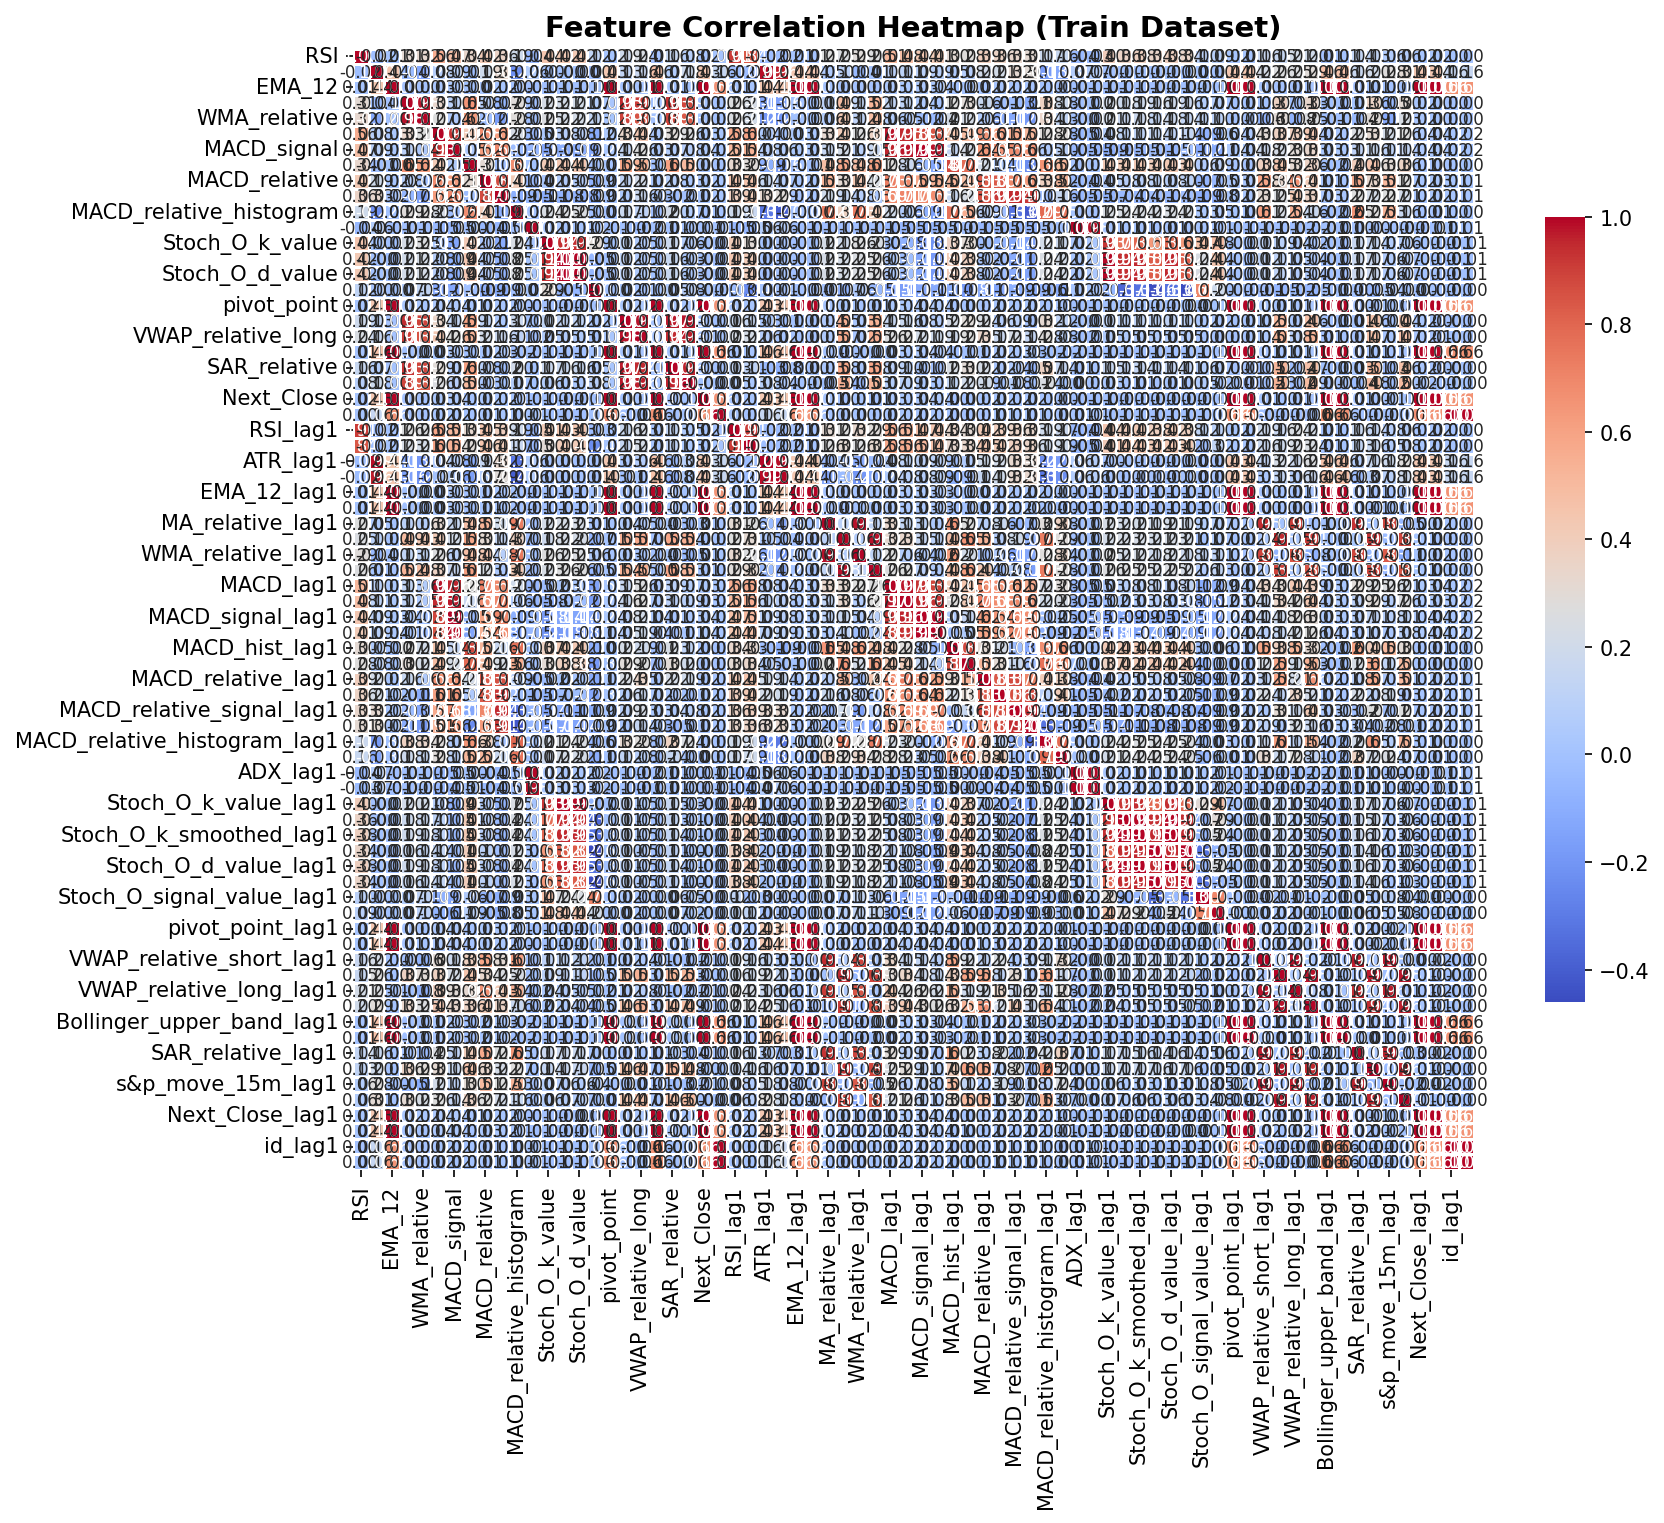

In [24]:
# ============================
# 🔥 Correlation Heatmap (Feature Relationships)
# ============================
plt.figure(figsize=(12, 10), dpi=150)
corr = X_train.corr(numeric_only=True)

# Draw heatmap
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.7},
    annot_kws={'size': 8}
)
plt.title("Feature Correlation Heatmap (Train Dataset)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [25]:
# features = df.drop('result',axis=1).columns
# target = 'result'

# X_train = df[features]
# y_train = df[target]

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
'''hyper_rf = {
    'n_estimators': [300, 600],
    'min_samples_leaf': [1, 3],
    'max_depth': [3, 5],
}

rf_gs = RandomForestClassifier(bootstrap=True, criterion='gini', random_state=42)

gs = RandomizedSearchCV(
    estimator=rf_gs,
    param_distributions=hyper_rf,
    scoring="f1",
    cv=3,
    n_iter=5,  
    verbose=1,
    n_jobs=-1,  
    random_state=42,
)

gs.fit(X_train, y_train)'''

'hyper_rf = {\n    \'n_estimators\': [300, 600],\n    \'min_samples_leaf\': [1, 3],\n    \'max_depth\': [3, 5],\n}\n\nrf_gs = RandomForestClassifier(bootstrap=True, criterion=\'gini\', random_state=42)\n\ngs = RandomizedSearchCV(\n    estimator=rf_gs,\n    param_distributions=hyper_rf,\n    scoring="f1",\n    cv=3,\n    n_iter=5,  \n    verbose=1,\n    n_jobs=-1,  \n    random_state=42,\n)\n\ngs.fit(X_train, y_train)'

In [28]:
'''print("Melhores parametros: ", gs.best_params_)'''

'print("Melhores parametros: ", gs.best_params_)'

In [29]:
rf = RandomForestClassifier(bootstrap = True, criterion = 'gini', random_state = 42,
                           n_estimators = 300, min_samples_leaf = 3, max_depth = 5 , verbose = 1)


In [30]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  5.5min
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  8.3min finished


,n_estimators,300
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
from sklearn.metrics import accuracy_score
import pandas as pd

def evaluate_model(model, X_train, y_train, X_test, y_test, sample_size=10):
    """
    Evaluate classification model performance on train & test sets.

    Args:
        model: Trained sklearn model
        X_train, y_train: Training data and labels
        X_test, y_test: Testing data and labels
        sample_size: Number of sample predictions to display

    Returns:
        Tuple of (train_accuracy, test_accuracy)
    """
    # 🔹 Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # 🔹 Accuracy
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    print(f"✅ Training Accuracy: {train_acc:.4f}")
    print(f"✅ Testing Accuracy:  {test_acc:.4f}\n")

    # 🔹 Show sample predictions
    comparison = pd.DataFrame({
        "Actual": y_test[:sample_size].values,
        "Predicted": y_pred_test[:sample_size]
    })
    print("📊 Sample Predictions (Test Set):")
    print(comparison.to_string(index=False))

    return train_acc, test_acc

train_acc, test_acc = evaluate_model(rf, X_train, y_train, X_test, y_test)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


✅ Training Accuracy: 0.9562
✅ Testing Accuracy:  0.9850

📊 Sample Predictions (Test Set):
 Actual  Predicted
      2          2
      2          2
      2          2
      2          2
      2          2
      2          2
      2          2
      2          2
      2          2
      2          2


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished


In [32]:
import pickle

# Suppose your trained model is 'rf'
with open("rf_model01.pkl", "wb") as file:
    pickle.dump(rf, file)

print("💾 Model saved as 'rf_model_withoutsampling.pkl'")

💾 Model saved as 'rf_model_withoutsampling.pkl'
